In [13]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [14]:
env = BlackjackEnv()

In [15]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        # Implement this!
        max_action = np.argmax(Q[observation])
        
        action_probabilities = np.zeros(nA)
        
        action_probabilities += epsilon / nA
        
        action_probabilities[max_action] += 1 - epsilon
        
        return action_probabilities

    return policy_fn

In [16]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        discount_factor: Lambda discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function taht takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # Implement this!
    for i in range(num_episodes):
        episode_finished = False
        observation = env.reset()
        
        stateactions_visited = []
        
        while not episode_finished:
            action = np.random.choice(np.arange(env.action_space.n), p=policy(observation))
            
            stateactions_visited.append((observation, action))
            returns_count[(observation, action)] += 1
            
            observation, reward, done, _ = env.step(action)
            
            for j, stateactions in enumerate(reversed(stateactions_visited)):
                returns_sum[stateactions] += (discount_factor ** j) * reward

            if done:
                episode_finished = True
                
                for stateactions in returns_sum.keys():
                    Q[stateactions[0]][stateactions[1]] = returns_sum[stateactions] / returns_count[stateactions]
    
    return Q, policy

In [17]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

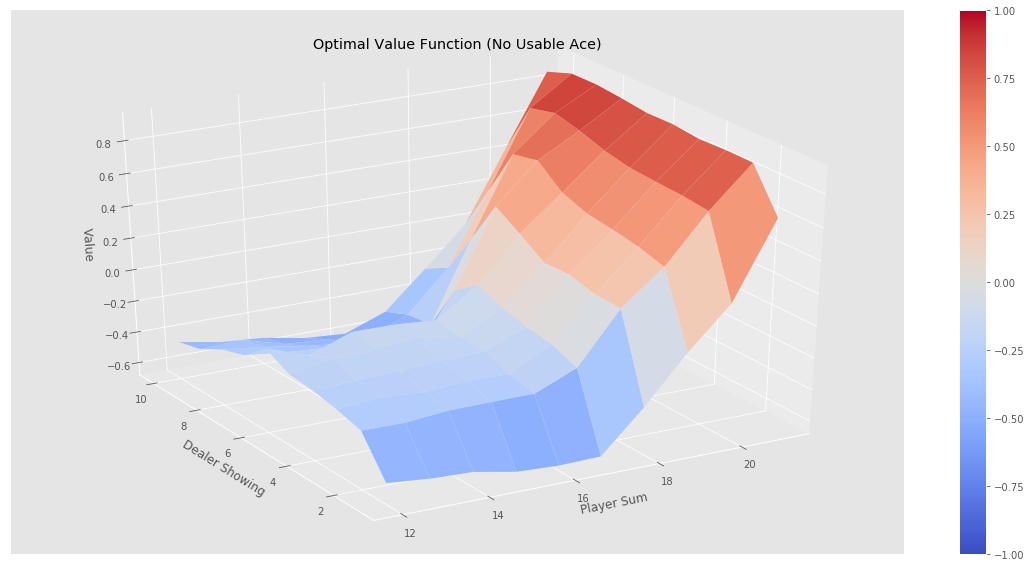

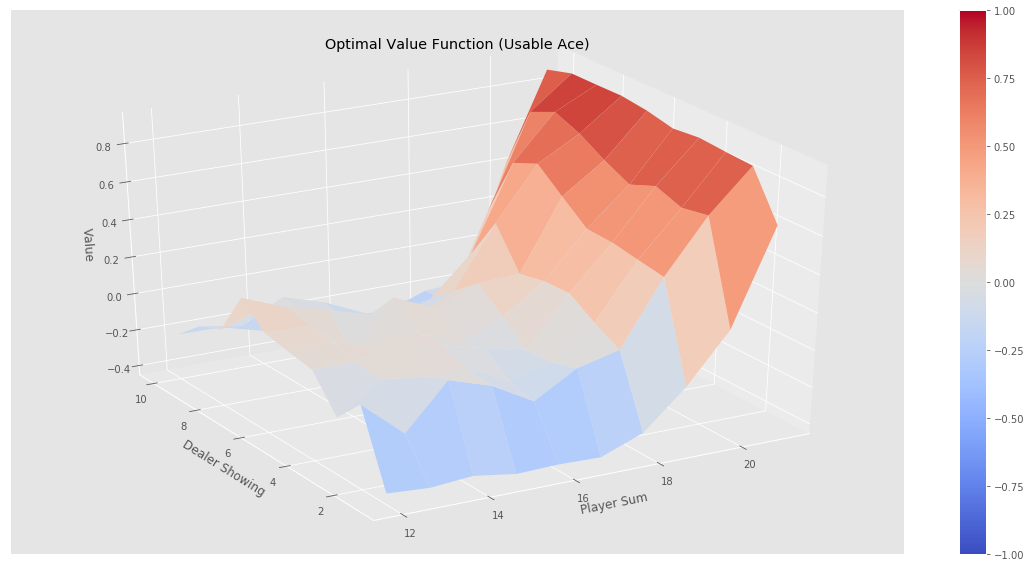

In [18]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")